In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
TRAIN_DIR = "../data/cnn/train"
VAL_DIR = "../data/cnn/val"


In [4]:
class_names = [
    "0","1","2","3","4","5","6","7","8","9",
    "A","B","C","D","E","F","G","H","I","J",
    "K","L","M","N","O","P","Q","R","S","T",
    "U","V","W","X","Y","Z"
]

num_classes = len(class_names)
print("Number of classes:", num_classes)


Number of classes: 36


In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])


In [6]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Training samples: 152391
Validation samples: 38111


In [7]:
class ASLCNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 14×14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 7×7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 3×3
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [8]:
model = ASLCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5060 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5060 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [9]:
def train_model(model, epochs=10):
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return train_accs, val_accs


In [10]:
train_accs, val_accs = train_model(model, epochs=20)


Epoch [1/20] Train Acc: 0.7355 | Val Acc: 0.9197
Epoch [2/20] Train Acc: 0.9366 | Val Acc: 0.9588
Epoch [3/20] Train Acc: 0.9601 | Val Acc: 0.9579
Epoch [4/20] Train Acc: 0.9711 | Val Acc: 0.9742
Epoch [5/20] Train Acc: 0.9773 | Val Acc: 0.9729
Epoch [6/20] Train Acc: 0.9805 | Val Acc: 0.9786
Epoch [7/20] Train Acc: 0.9820 | Val Acc: 0.9772
Epoch [8/20] Train Acc: 0.9848 | Val Acc: 0.9809
Epoch [9/20] Train Acc: 0.9854 | Val Acc: 0.9864
Epoch [10/20] Train Acc: 0.9870 | Val Acc: 0.9822
Epoch [11/20] Train Acc: 0.9879 | Val Acc: 0.9505
Epoch [12/20] Train Acc: 0.9885 | Val Acc: 0.9872
Epoch [13/20] Train Acc: 0.9885 | Val Acc: 0.9809
Epoch [14/20] Train Acc: 0.9897 | Val Acc: 0.9864
Epoch [15/20] Train Acc: 0.9903 | Val Acc: 0.9899
Epoch [16/20] Train Acc: 0.9907 | Val Acc: 0.9891
Epoch [17/20] Train Acc: 0.9916 | Val Acc: 0.9867
Epoch [18/20] Train Acc: 0.9913 | Val Acc: 0.9875
Epoch [19/20] Train Acc: 0.9914 | Val Acc: 0.9871
Epoch [20/20] Train Acc: 0.9920 | Val Acc: 0.9893


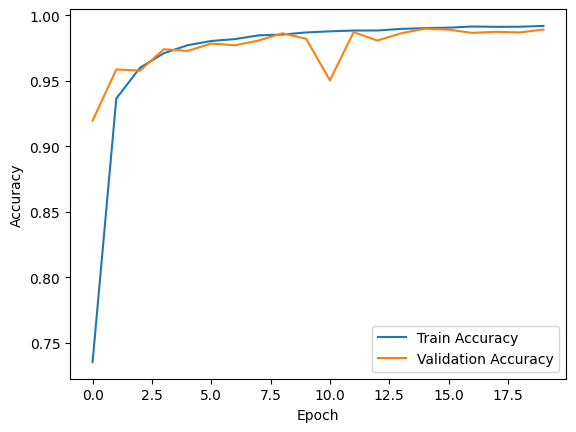

In [11]:
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [12]:
os.makedirs("../models/cnn", exist_ok=True)

torch.save(model.state_dict(), "../models/cnn/asl_cnn.pth")
print("CNN model saved!")


CNN model saved!


In [13]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Validation Accuracy:", correct / total)


Validation Accuracy: 0.9892681902862691


In [14]:
from PIL import Image

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    return class_names[pred.item()], conf.item()
